In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Convolutional Neural Network
### Fashion MNIST Dataset

In [8]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from collections.abc import Callable
from typing import Literal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 

%matplotlib inline

In [9]:
# gpus = tf.config.list_physical_devices('GPU')

# try:
#     for g in gpus:
#         tf.config.experimental.set_memory_growth(g, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print (len(gpus), 'Phusical GPUs', len(logical_gpus), 'Logical GPUs')
# except:
#     print ('invalid device')

In [10]:
###----------------
### Some parameters
###----------------

inpDir = '../../input'
outDir = '../output'
subDir = 'flower_photos'
modelDir = '.../models'
altname= 'cc_base'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

TEST_SIZE = 0.2
EPOCHS = 50 # number of epochs
ALPHA = 0.005 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32
LR_PATIENCE = 3
FACTOR_LR = 0.5
TRAIN_SIZE = 256 # fix size of train set sot that we have batches of same size
PATIENCE = 4

IMG_HEIGHT = 190
IMG_WIDTH = 190

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

In [11]:


def fn_plot_label(train_ds , test_ds):
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)

    train_labels = tf.concat([lbl for img, lbl in train_ds], axis=0).numpy()

    unique, _, counts = tf.unique_with_counts(train_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue')

    plt.xticks(range(len(unique)), class_names)

    plt.title('training set')

    plt.subplot(1,2,2)

    test_labels = tf.concat([lbl for img, lbl in test_ds], axis=0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('testing set')
    
                                     


## Generate Data Set
Flower Dataset

In [12]:
class_label = {0 : 'Daisy',
               1 : 'Dandelion',
               2 : 'Roses',
               3 : 'Sunflowers',
               4 : 'Tupils',
               }

In [13]:
data_dir = os.path.join(inpDir, subDir)
data_dir

'../../input/flower_photos'

In [14]:
os.listdir(data_dir)

['sunflowers', 'LICENSE.txt', 'tulips', 'dandelion', 'roses', 'daisy']

In [15]:
## DATASET for training

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = TEST_SIZE,
    subset = 'training',
    seed = RANDOM_STATE,
    image_size= [IMG_HEIGHT, IMG_WIDTH],
    batch_size= BATCH_SIZE
)

## DATASET for testing

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = TEST_SIZE,
    subset = 'validation',
    seed = RANDOM_STATE,
    image_size= [IMG_HEIGHT, IMG_WIDTH],
    batch_size= BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

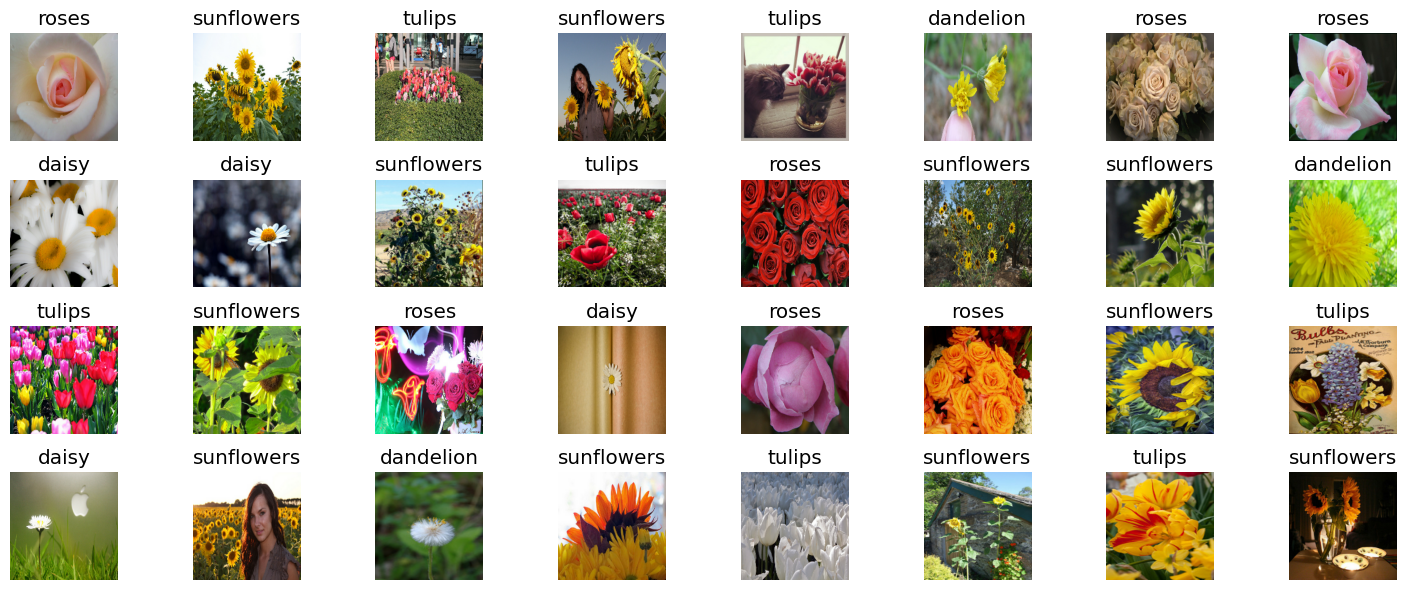

In [17]:
plt.figure(figsize=(15,6))

for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8),8, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[labels[i]])
    plt.tight_layout()
plt.show()

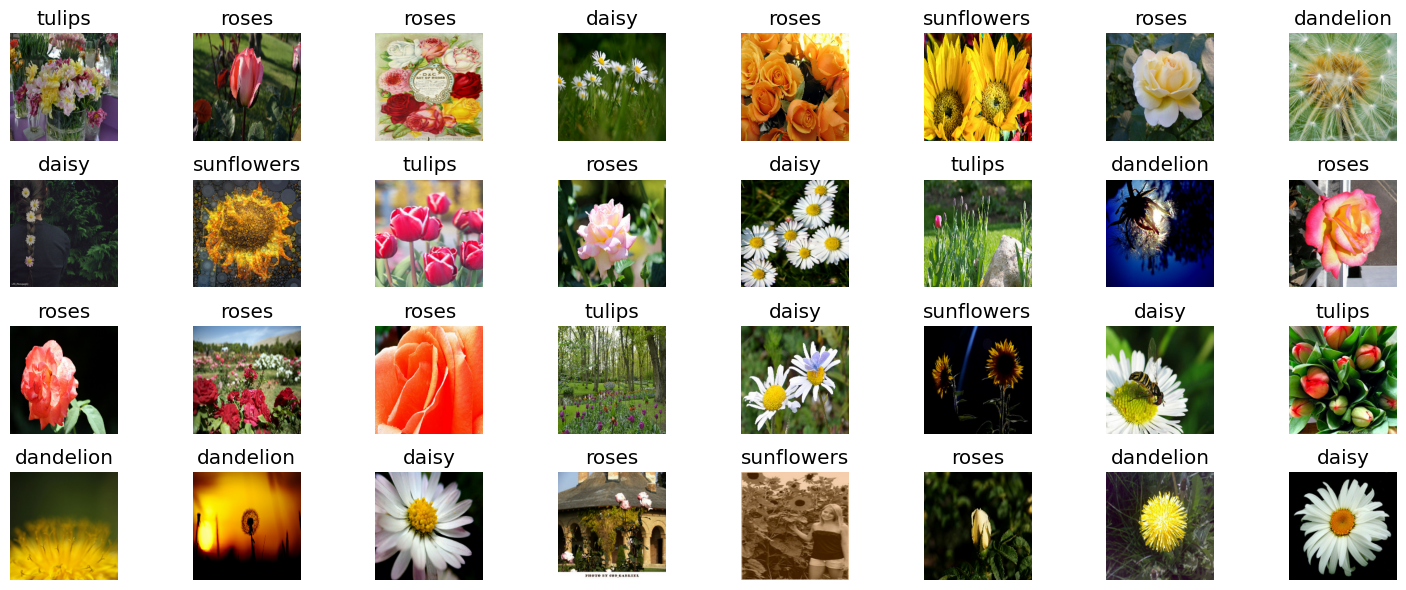

In [18]:
plt.figure(figsize=(15,6))

for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8),8, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[labels[i]])
    plt.tight_layout()
plt.show()

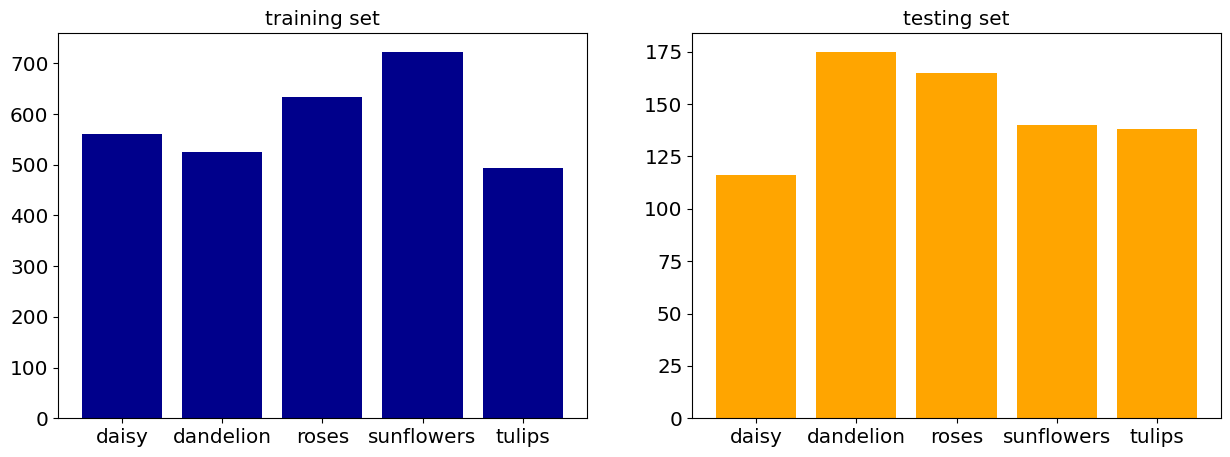

In [19]:
fn_plot_label(train_ds, test_ds)

In [20]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

## Random Zoom

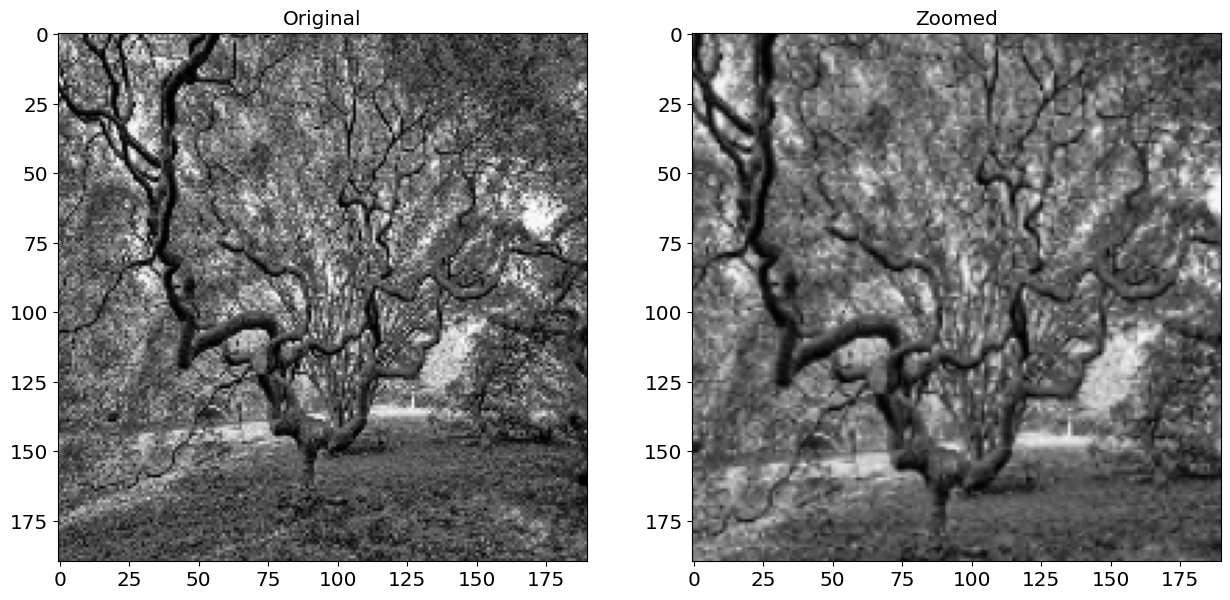

In [21]:
layer = tf.keras.layers.RandomZoom(height_factor = (-0.2, -0.2),
                                   width_factor = (-0.2, -0.2))
plt.figure()
img_num = 3

for images, labels in test_ds.take(1):
    out_images = layer(images)

    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(images[img_num].numpy().astype('uint8'))

    plt.subplot(1,2,2)
    plt.title('Zoomed')
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

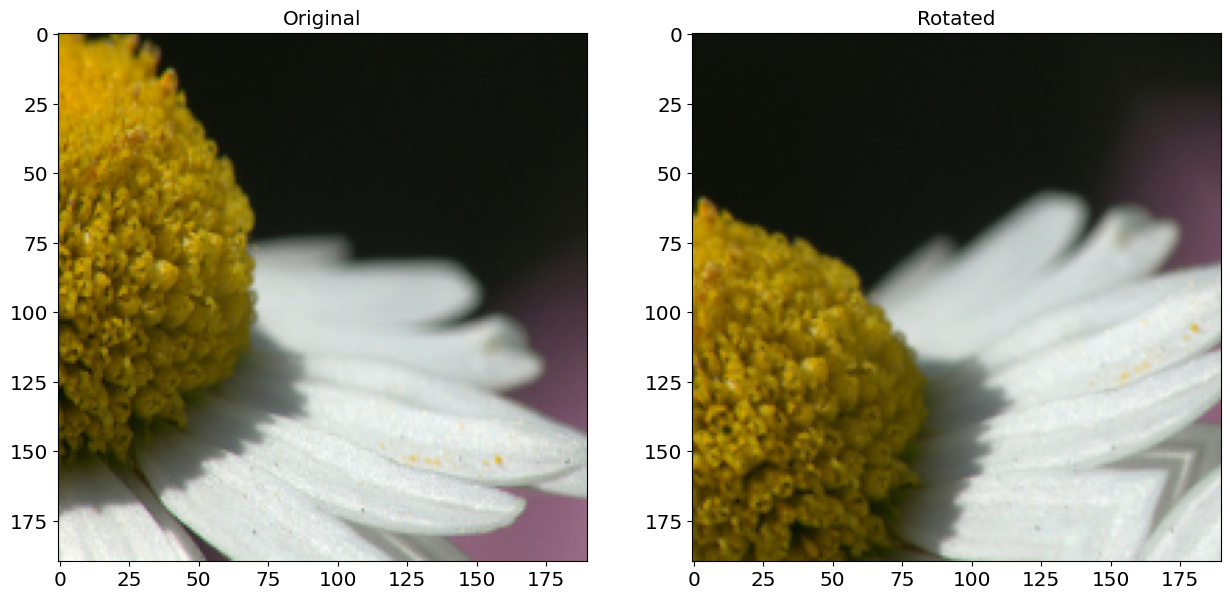

In [22]:
layer = tf.keras.layers.RandomRotation(
    factor=(-0.2, 0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    fill_value=0.0,
)
plt.figure()
img_num = 3

for images, labels in test_ds.take(1):
    out_images = layer(images)

    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(images[img_num].numpy().astype('uint8'))

    plt.subplot(1,2,2)
    plt.title('Rotated')
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

In [23]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(factor=(-0.3, 0.3), fill_mode='reflect',
                                interpolation='bilinear', fill_value=0.0,),
  # tf.keras.layers.RandomRotation(factor=(-0.6, 0.6), fill_mode='reflect',
  #                               interpolation='bilinear', fill_value=0.0,),
  # tf.keras.layers.RandomContrast(
  #   factor=(1-0.5, 1+0.5)),
  # tf.keras.layers.RandomBrightness(
  #   factor=(-1,1), value_range=(0, 255)),
  # tf.keras.layers.RandomTranslation(
  #   height_factor = (-0.3, 0.3),
  #   width_factor = (-0.3, 0.3),
  #   fill_mode='reflect',
  #   interpolation='bilinear',
  #   seed=None,
  #   fill_value=0.0)

])


In [25]:
#Model

model= tf.keras.Sequential()

model.add(tf.keras.layers.Rescaling(1/255.))
#model.add(data_augmentation)
##set 1
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))

model.add(tf.keras.layers.MaxPool2D(2,2))  # 94 X 94 X 32

##set 2
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))

model.add(tf.keras.layers.MaxPool2D(2,2))  # 4 X 4 X 64

##set 3
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))

model.add(tf.keras.layers.MaxPool2D(2,2))  # 4 X 4 X 128

##set 4
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu'))

model.add(tf.keras.layers.MaxPool2D(2,2))  # 4 X 4 X 256

##set 5
model.add(tf.keras.layers.Conv2D(512, (3,3), activation='relu'))

model.add(tf.keras.layers.MaxPool2D(2,2))  # 4 X 4 X 512

# ## Set 6
model.add(tf.keras.layers.Conv2D(1024, (3,3), activation='relu'))


## Set 7
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(1024, activation='relu'))

# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(5))

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss',
    patience= PATIENCE,
    mode = 'auto',
    baseline= None,
    verbose = 1,
    restore_best_weights=True,
    start_from_epoch= 0
)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor= 'val_loss',
    factor= FACTOR_LR,
    patience= PATIENCE,
    mode = 'auto',
    verbose = 1,
)



In [27]:
modelFile = os.path.join(modelDir, subDir, altname)

model_callback = tf.keras.callbacks.ModelCheckpoint(
    modelFile,
    monitor= 'val_loss',
    mode = 'auto',
    verbose = 1,
    save_best_only=True,
    save_weights_only=True
)

In [28]:
optim = tf.keras.optimizers.Adam(learning_rate = ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model.compile(optimizer = optim, loss = loss_fn, metrics = ['accuracy'])

In [29]:
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, verbose = 1,batch_size=BATCH_SIZE,
                    callbacks=[early_stopping, lr_decay])

Epoch 1/50


92/92 [==============================] - 116s 1s/step - loss: 1.3570 - accuracy: 0.4377 - val_loss: 1.6825 - val_accuracy: 0.3856 - lr: 5.0000e-04
Epoch 2/50
 3/92 [..............................] - ETA: 1:34 - loss: 1.4010 - accuracy: 0.4271

KeyboardInterrupt: 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 190, 190, 3)       0         
                                                                 
 sequential (Sequential)     (None, 190, 190, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 188, 188, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 94, 94, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 16)        0         
 g2D)                                                 

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,1.375043,0.404292,1.508118,0.320163,0.0005
1,1.140434,0.531335,1.450473,0.430518,0.0005
2,1.044348,0.587193,1.289295,0.491826,0.0005
3,0.961879,0.618869,1.131704,0.591281,0.0005
4,0.905894,0.648842,0.972807,0.640327,0.0005


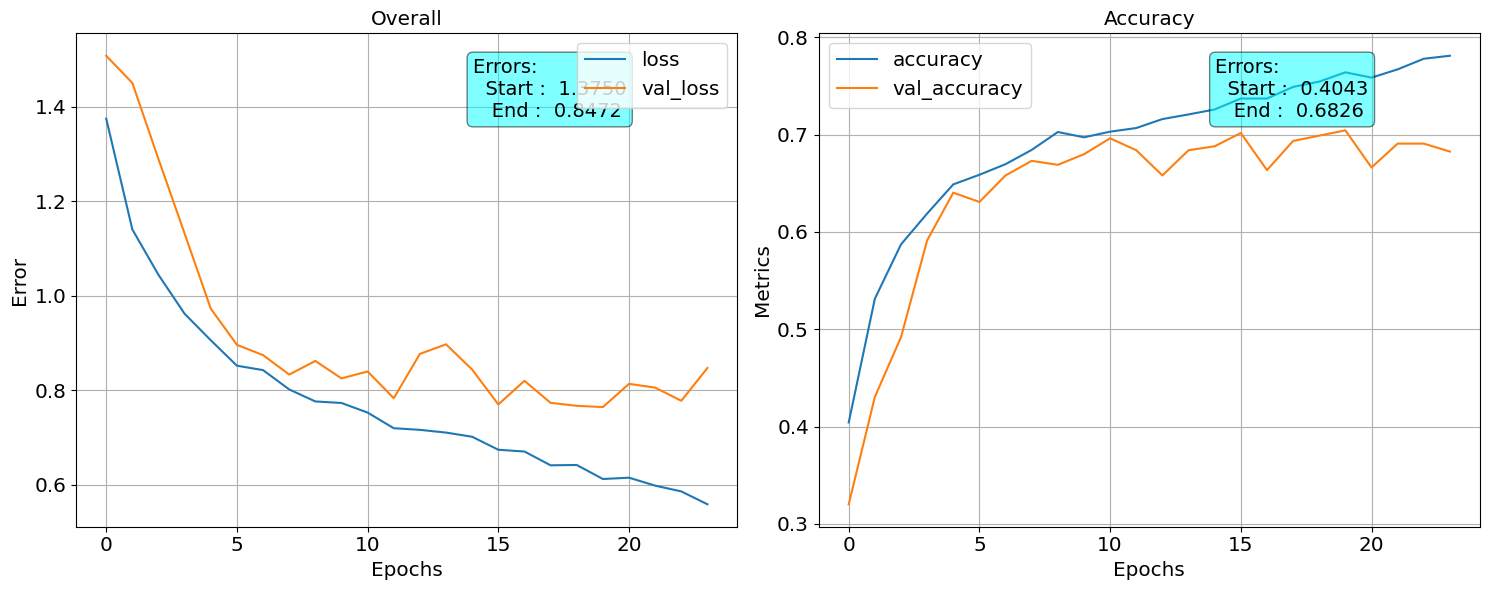

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]
y1 = loss_df.columns[0]
y2 = loss_df.columns[2]

loss_df.plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]
y1 = loss_df.columns[1]
y2 = loss_df.columns[3]
loss_df[-l_range:].plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.set_title(y1.capitalize())
ax.grid();
plt.tight_layout()

In [ ]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy,lr
19,0.612235,0.763965,0.764472,0.70436,0.0005
